# **Sentiment analysis with OpenAI embeddings**

![antio-ai.jpg](img/antio-ai.jpg)

$^{1}$Photo by Eduard X (Dec 2022) taken from [Bidebide](https://www.google.com/maps/place/Bar-Restaurante+Bidebide+-+Zumarraga/@43.0916521,-2.3038457,15z/data=!4m6!3m5!1s0xd502df21409c619:0xbbdffd835d70d9e4!8m2!3d43.0916521!4d-2.3038457!16s%2Fg%2F11c4xc6ms1?entry=ttu) restaurant in Google Maps.

Feb, 2024
> *OpenAI API, Sentiment Analysis*

## Background
Last year, I worked on a [project](https://mikel-imaz.github.io/projects/notebooks/antio.html) where I scraped reviews of a restaurant from Google Maps to analyze the sentiments expressed in those reviews. In the project, I employed the basic Natural Language Processing technique of encoding words into numerical values and then used a basic machine learning model (logistic regression) to classify reviews as positive or negative. Now, seizing the opportunity provided by OpenAI to utilize its word vectorization model, I aim to revisit the same project to compare the results obtained with this new approach.

In [16]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import other packages
from openai import OpenAI
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from scipy.spatial import distance

# Assign API key
api_key = "my-secret-key"

# OpenAI model
model = "text-embedding-ada-002"

## The data
I retrieve the data from the reviews that I saved in a CSV file.

In [2]:
# Read csv into a dataframe dropping rows with missing values
antio = pd.read_csv('data/antio-reviews.csv', usecols=['stars', 'text']).dropna()
antio.head()

,stars,text
0,4 estrellas,Excelente trato y buena relación precio-calida...
1,5 estrellas,Muy buen menú con mucha variedad y buen produc...
2,4 estrellas,"Comida buenísima y buena atención, vistas mara..."
3,5 estrellas,"He comido el menú del día por 13 euros, y tien..."
4,4 estrellas,Restaurante grande con unos menús muy ricos y ...


## Data processing
The string type stars column needs to be converted into integer values.

In [3]:
# Convert stars column from string to number
antio["stars_n"] = [stars[1] for stars in antio["stars"]]
antio["stars_n"] = antio["stars_n"].astype(str).astype(int)

# Rearrange dataframe with columns stars, text
antio = antio.iloc[:, [2, 1]]
antio = antio.rename(columns={"stars_n": "stars"})

# Show dataframe info
print(antio.info())

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   193 non-null    int32 
 1   text    193 non-null    object
dtypes: int32(1), object(1)
memory usage: 3.8+ KB
None


## Create review texts' embeddings
I define a function that creates embeddings from a list of texts and use it for the reviews.

In [4]:
# Set API key
client = OpenAI(api_key=api_key)

# Define a create_embeddings function
def create_embeddings(texts):
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    response_dict = response.model_dump()
    return [data['embedding'] for data in response_dict['data']]

# Create a list of review texts
review_texts = antio['text'].tolist()

# Create embeddings for those texts
review_embeddings = create_embeddings(review_texts)

## Sentiment analysis: stars (5 categories)
At first, I classify the reviews into 5 different categories corresponding to the ratings that customers give by assigning stars. This way, I'll be able to directly compare the results obtained by OpenAI's semantic model with the ratings given by customers.

In [5]:
# Define sentiments
sentiments = [{'label': 1, 'description': 'A very negative restaurant review'},
              {'label': 2, 'description': 'A negative restaurant review'},
              {'label': 3, 'description': 'A neutral restaurant review'},
              {'label': 4, 'description': 'A positive restaurant review'},
              {'label': 5, 'description': 'A very positive restaurant review'}]

# Create a list of class descriptions from the sentiment descriptions
class_descriptions = [sentiment['description'] for sentiment in sentiments]

# Create embeddings for class_descriptions
class_embeddings = create_embeddings(class_descriptions)

# Define a function to return the minimum distance and its index
def find_closest(query_vector, embeddings):
    distances = []
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(query_vector, embedding)
        distances.append({"distance": dist, "index": index})
    return min(distances, key=lambda x: x["distance"])

# Find closest distance
labels = []
for index, review in enumerate(review_texts):
    # Find the closest distance and its index using find_closest()
    closest = find_closest(review_embeddings[index], class_embeddings)
    # Subset sentiment label using the index from closest
    label = sentiments[closest['index']]['label']
    # Append to list
    labels.append(label)

# Make a copy of the dataframe
antio5 = antio.copy()

# Create column with closest label
antio5['label'] = labels

# Create column mismatch between stars and label
antio5.loc[:, 'mismatch'] = abs(antio5['label'] - antio5['stars'])
antio5

,stars,text,label,mismatch
0,4,Excelente trato y buena relación precio-calida...,5,1
1,5,Muy buen menú con mucha variedad y buen produc...,5,0
2,4,"Comida buenísima y buena atención, vistas mara...",5,1
3,5,"He comido el menú del día por 13 euros, y tien...",5,0
4,4,Restaurante grande con unos menús muy ricos y ...,5,1
...,...,...,...,...
188,5,(Traducido por Google) Gran lugar\r\n\r\n(Orig...,5,0
189,5,(Traducido por Google) Increíble vista\r\n\r\n...,5,0
190,4,(Traducido por Google) Hermoso menú y temperat...,5,1
193,5,(Traducido por Google) Gran lugar\r\n\r\n(Orig...,5,0


In [30]:
# Compute mismatches
mismatches = antio5['mismatch'].value_counts()
print(mismatches)

# Print accuracy rate
print(f'\nAccuracy rate -> {(mismatches[0] / len(antio5)):.2f}')

mismatch
0    88
1    70
2    23
3     6
4     6
Name: count, dtype: int64

Accuracy rate -> 0.46


The results indicate that the model only matched the stars assigned by customers in 88 out of 193 reviews, providing an accuracy rate of 46%.

Out of curiosity, let's take a look at the 6 reviews that deviated the most, to check why this might have happened.

In [31]:
# Select rows with maximum mismatch of 4 stars
antio5_mis4 = antio5.loc[antio5['mismatch'] == 4, :]
antio5_mis4

,stars,text,label,mismatch
41,1,El sitio es espectacular. El servicio es inesi...,5,4
60,1,El precio un poco excesivo para todo su conjun...,5,4
106,1,"El sitio esta de lujo, pero deja mucho que des...",5,4
146,1,Me gusta mucho,5,4
157,1,"Cerveza caliente y camareros bordes, la combin...",5,4
187,1,(Traducido por Google) Nos sentamos a la mesa ...,5,4


In [40]:
# Transform dataframe into list of dictionary to show full text when printed
reviews = [antio5_mis4.iloc[row, :].to_dict() for row in range(len(antio5_mis4))]

# Print
for i in range(len(antio5_mis4)):
    print(f'{i + 1} --> {reviews[i]}\n')

1 --> {'stars': 1, 'text': 'El sitio es espectacular. El servicio es inesistente desde qué te toman la comanda, asta qué llega él pri. plato puedes hecharte una siesta y ya no te digo nada para él seg. plato etc.... Lo que no entiendo como sigue teniendo el mismo dueño la explotación en fin un autentico desastre. Y llevo 35 años comiendo fuera de casa, así que algo de esperiencia tendré.', 'label': 5, 'mismatch': 4}

2 --> {'stars': 1, 'text': 'El precio un poco excesivo para todo su conjunto, teniendo en cuenta sobre todo el trato del personal. La comida está buena, pero no tanto como para pagar 26€ por un menú que, a primera vista llamaba mucho la atención, pero después dejó mucho que desear.', 'label': 5, 'mismatch': 4}

3 --> {'stars': 1, 'text': 'El sitio esta de lujo, pero deja mucho que desear.\r\nCroquetas congeladas, bacalao sin acabar de frerir, la carrillera de la carta es redondo de ternera, ...\r\nSolo lo salvan las camareras, que estan atentas a todo y pidiendo disculpas.

In the review number 4 on this list, the issue arises from the inconsistency of the customer, who assigned only one star when the corresponding text they wrote indicated satisfaction, and therefore the model correctly deduced that it deserved 5 stars.

In the rest of the reviews, the model misinterpreted the text, probably due to reasons such as: The use of positive words in a context that actually indicated dissatisfaction; Poor writing style that hinders comprehension; Texts in languages other than English.

## Sentiment analysis: good/bad (2 categories)
To better compare the results of this model with those I obtained in the original project, I tried asking it to classify the texts in a binary manner, that is, into good and bad reviews. Just as I did in the original project, to simplify and not have to take the trouble of assigning it myself by reading each text, I considered a review to be good if it had been assigned 5 or 4 stars, while a bad one was one that had received 1, 2, or 3 stars.

In [23]:
# Define sentiments
sentiments = [{'label': 0, 'description': 'A negative restaurant review'},
              {'label': 1, 'description': 'A positive restaurant review'}]

# Create a list of class descriptions from the sentiment descriptions
class_descriptions = [sentiment['description'] for sentiment in sentiments]

# Create embeddings for class_descriptions
class_embeddings = create_embeddings(class_descriptions)

# Find closest distance
labels = []
for index, review in enumerate(review_texts):
    # Find the closest distance and its index using find_closest()
    closest = find_closest(review_embeddings[index], class_embeddings)
    # Subset sentiment label using the index from closest
    label = sentiments[closest['index']]['label']
    # Append to list
    labels.append(label)

# Make a copy of the dataframe
antio2 = antio.copy()

# Include stars prediction results in dataframe
antio2['label'] = labels

# Create column representing stars values 4 or 5
antio2['stars_4_5'] = ((antio2['stars'] == 5) | (antio2['stars'] == 4)).replace({True: 1, False: 0})
antio2

,stars,text,label,stars_4_5
0,4,Excelente trato y buena relación precio-calida...,1,1
1,5,Muy buen menú con mucha variedad y buen produc...,1,1
2,4,"Comida buenísima y buena atención, vistas mara...",1,1
3,5,"He comido el menú del día por 13 euros, y tien...",1,1
4,4,Restaurante grande con unos menús muy ricos y ...,1,1
...,...,...,...,...
188,5,(Traducido por Google) Gran lugar\r\n\r\n(Orig...,1,1
189,5,(Traducido por Google) Increíble vista\r\n\r\n...,1,1
190,4,(Traducido por Google) Hermoso menú y temperat...,1,1
193,5,(Traducido por Google) Gran lugar\r\n\r\n(Orig...,1,1


In [41]:
# Print results
y_test = antio2['stars_4_5']
y_predicted = antio2['label']

print('Confusion matrix: \n\n', confusion_matrix(y_test, y_predicted))
print('\nReport: \n', classification_report(y_test, y_predicted,
                                            target_names=["bad reviews ->", "good reviews ->"]))

Confusion matrix: 

 [[ 29  36]
 [  2 126]]

Report: 
                  precision    recall  f1-score   support

 bad reviews ->       0.94      0.45      0.60        65
good reviews ->       0.78      0.98      0.87       128

       accuracy                           0.80       193
      macro avg       0.86      0.72      0.74       193
   weighted avg       0.83      0.80      0.78       193



The accuracy with which it detects whether reviews are good or bad is quite high, especially for the bad ones (29 correct negative reviews and only 2 were misclassified as negative). However, if we consider that this automatic classification would be more useful if it were able to capture the maximum number of negative reviews (to provide a prompt response to all dissatisfied customers), then we see that the **sensitivity (recall) of 0.45** is quite low in this case (it captured 29 negative reviews, but missed 36 that were also negative). For this specific case, the result obtained is worse than in the original basic project I did last year, in which I obtained a recall of 0.7.

## Visualizing
Simply to have a visual reference of what the model is doing, I reduce the dimensionality of the vectors to 2 in order to plot their position on a plane and verify that indeed the reviews of each type are spatially clustered.

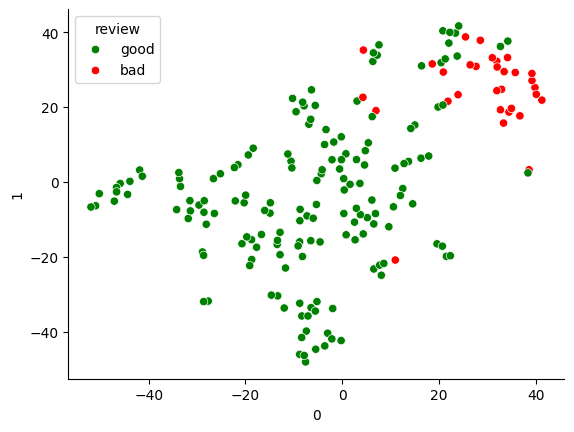

In [43]:
# Reduce the number of embeddings dimensions to two using t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(np.array(review_embeddings))

# Create an auxiliary dataframe to plot with seaborn
df_visu = pd.DataFrame(embeddings_2d.tolist())
df_visu['review'] = antio2['label'].tolist()
df_visu['review'] = df_visu['review'].replace({0: 'bad', 1: 'good'})

# Plot
sns.scatterplot(x=0, y=1, hue='review', data=df_visu, palette=['green', 'red'])
sns.despine()
plt.show()

## Conclusion

Despite the ease of use and the impressive ability of OpenAI's semantic model to assign sentiment to each review, in this project, when it came to automatically detecting *all* the negative reviews, it did not give me better results than the ones I obtained last year using more basic Machine Learning techniques.